In [47]:
import numpy as np # import library to handle data in a vectorized manner

import pandas as pd # import library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests #import library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # import map rendering library

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # import library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [48]:
CLIENT_ID = 'ENNZUXAOREVESSHOJ0LWAT2BUG5OPEPX04CW2LVHUZTAPFKE' 
CLIENT_SECRET = '1V00JTQVVPU1TZ3ZNVN5A0NE2CA43XSITUDRPA4ND2RB5YDT' 
VERSION = '20180604'

In [59]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [60]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [61]:
ny_data.shape


(306, 4)

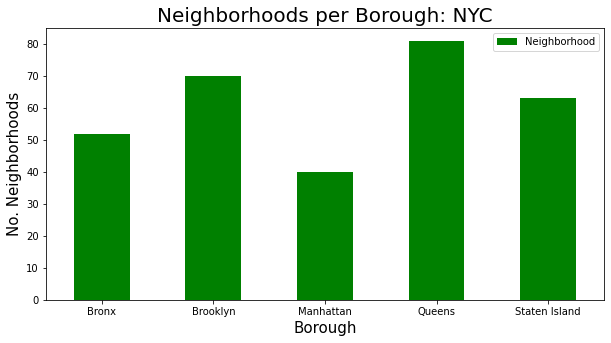

In [62]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [98]:
# queens has most neighborhoods
# prepare neighborhood list that contains Russian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
russian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    russian_restaurants=venues[venues['Category']=='Russian Restaurant']   
    print('(',count,'/',len(ny_data),')','Russian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(russian_restaurants)))
    print(row)
    for resturant_detail in russian_restaurants.values.tolist():
        id, name , category=resturant_detail
        russian_rest_ny = russian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Russian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Russian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Russian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Russian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Russian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Russian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Russian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Russian Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Russian Restaurants in Norwood, Bronx:0
['

In [99]:
russian_rest_ny.to_csv('russian_rest_ny_tocsv1.csv')

In [100]:
russian_ny = pd.read_csv('russian_rest_ny_tocsv1.csv')
russian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka
1,Brooklyn,Brighton Beach,4245f780f964a52070201fe3,Tatiana Restaurant
2,Brooklyn,Brighton Beach,4c1ea63763750f474c19ba67,Volna Café
3,Brooklyn,Bath Beach,4d6189d81939a35dbb7d2eee,KARELIA
4,Staten Island,Midland Beach,51f092a2498e9f9edd14b597,Verrazano Grill


In [101]:
russian_rest_ny.shape


(6, 4)

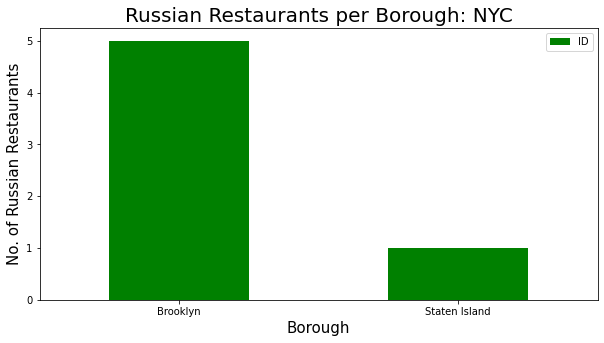

In [102]:
russian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Russian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Russian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

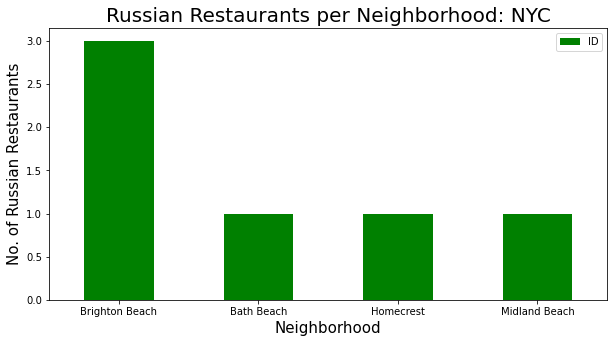

In [103]:
NOofNeigh = 6 # top number for graphing all the same past 6
russian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Russian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Russian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [104]:
russian_rest_ny[russian_rest_ny['Neighborhood']=='Brighton Beach']

,Borough,Neighborhood,ID,Name
0,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka
1,Brooklyn,Brighton Beach,4245f780f964a52070201fe3,Tatiana Restaurant
2,Brooklyn,Brighton Beach,4c1ea63763750f474c19ba67,Volna Café


In [105]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
russian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in russian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(russian_rest_ny),')','processed')
    russian_rest_stats_ny = russian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
russian_rest_stats_ny.head()

{'meta': {'code': 200, 'requestId': '601f58ceddc7935877532fcf'}, 'response': {'venue': {'id': '4ac69109f964a52017b520e3', 'name': 'Skovorodka', 'contact': {'phone': '7186153096', 'formattedPhone': '(718) 615-3096', 'twitter': 'skovorodka', 'facebook': '237878329986', 'facebookUsername': 'SkovorodkaNY', 'facebookName': 'Skovorodka'}, 'location': {'address': '615 Brighton Beach Ave', 'lat': 40.57785097056201, 'lng': -73.96096839229678, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57785097056201, 'lng': -73.96096839229678}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['615 Brighton Beach Ave', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/skovorodka/4ac69109f964a52017b520e3', 'categories': [{'id': '5293a7563cf9994f4e043a44', 'name': 'Russian Restaurant', 'pluralName': 'Russian Restaurants', 'shortName': 'Russian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka,95,7.7,48
1,Brooklyn,Brighton Beach,4245f780f964a52070201fe3,Tatiana Restaurant,161,7.0,67
2,Brooklyn,Brighton Beach,4c1ea63763750f474c19ba67,Volna Café,34,6.2,21
3,Brooklyn,Bath Beach,0,0,0,0.0,0
4,Staten Island,Midland Beach,0,0,0,0.0,0


In [106]:
russian_rest_stats_ny.to_csv('russian_rest_stats_ny_csv.csv') 


In [107]:
russian_rest_stats_ny.shape


(6, 7)

In [108]:
russian_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       6 non-null      object 
 1   Neighborhood  6 non-null      object 
 2   ID            6 non-null      object 
 3   Name          6 non-null      object 
 4   Likes         6 non-null      object 
 5   Rating        6 non-null      float64
 6   Tips          6 non-null      object 
dtypes: float64(1), object(6)
memory usage: 464.0+ bytes


In [109]:
russian_rest_stats_ny['Likes'] = russian_rest_stats_ny['Likes'].astype('float64')
russian_rest_stats_ny['Tips'] = russian_rest_stats_ny['Tips'].astype('float64')
russian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       6 non-null      object 
 1   Neighborhood  6 non-null      object 
 2   ID            6 non-null      object 
 3   Name          6 non-null      object 
 4   Likes         6 non-null      float64
 5   Rating        6 non-null      float64
 6   Tips          6 non-null      float64
dtypes: float64(3), object(4)
memory usage: 464.0+ bytes


In [110]:
russian_rest_stats_ny.describe()


,Likes,Rating,Tips
count,6.000000,6.000000,6.000000
mean,55.166667,4.816667,27.166667
std,62.486532,3.782283,26.588845
min,0.000000,0.000000,0.000000
25%,8.500000,1.550000,5.250000
50%,37.500000,6.600000,24.000000
75%,81.500000,7.525000,42.750000
max,161.000000,8.000000,67.000000


In [111]:
# Resturant with maximum Likes
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood              Brighton Beach
ID              4245f780f964a52070201fe3
Name                  Tatiana Restaurant
Likes                                161
Rating                                 7
Tips                                  67
Name: 1, dtype: object

In [112]:
# Resturant with maximum Ratings
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                   Homecrest
ID              4a2937fcf964a52069951fe3
Name                           Stolovaya
Likes                                 41
Rating                                 8
Tips                                  27
Name: 5, dtype: object

In [113]:
# Resturant with maximum Tips
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood              Brighton Beach
ID              4245f780f964a52070201fe3
Name                  Tatiana Restaurant
Likes                                161
Rating                                 7
Tips                                  67
Name: 1, dtype: object

In [114]:
ny_neighborhood_stats=russian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
2,Homecrest,8.000000
1,Brighton Beach,6.966667
0,Bath Beach,0.000000
3,Midland Beach,0.000000


In [115]:
ny_borough_stats=russian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Brooklyn,5.78
1,Staten Island,0.00


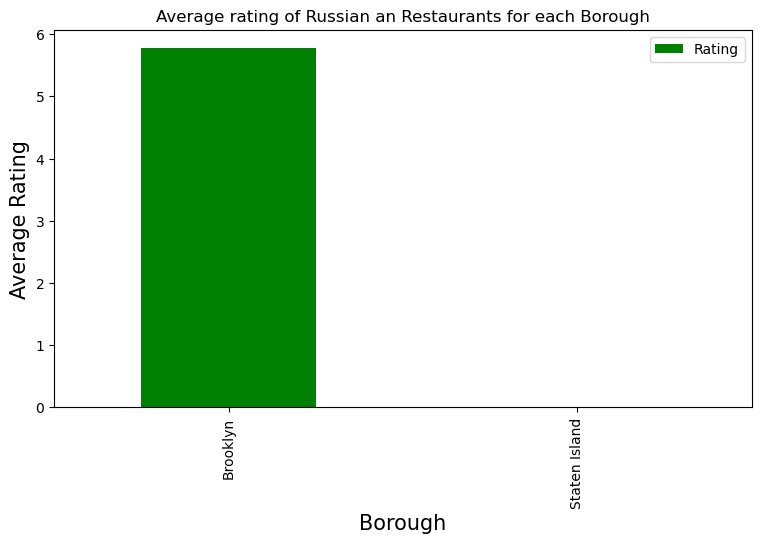

In [116]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Russian an Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
russian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [117]:

ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Homecrest,8.0


In [118]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Homecrest,40.598525,-73.959185,8.0


In [119]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [120]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

# Conclusion

